In this notebook I try incorporate one small part of the neural network used in [this work at google](https://ai.googleblog.com/2020/03/a-neural-weather-model-for-eight-hour.html).

Namely this is to use a large spatial scale but coarse satellite/NWP as well as a smaller spatial scale but fine resolution one. Then combine these to make predictions. In previous notebooks I had been using either 22km or 144km based on whether I was nowcasting or predicting a sequence. I think this hybrid method is a really nice compromise.


- [Load PV](#load_pv)
- [Intantiate sat/NWP loaders](#satnwp_loaders)
- [Define network classes](#net_classes)
- [Instantiate model](#instaniate_models)
- [Train models](#train)
- [Show sequence examples](#sequences)
- [Evaluate accuracy](#accuracy)
- [Plot distributions](#distributions)



In [1]:
import src
import imp
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


<a id='load_pv' ></a>

## Load and process PV data

In [3]:
pv_metadata_df = src.data.load_pv.load_pv_metadata()

In [4]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,519080.191006,244623.301288
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,471786.316866,176769.072244
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,338853.840270,478417.935178
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,467806.490433,135244.187025
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,355234.617987,397009.685712


In [5]:
pv_power_df = src.data.load_pv.load_pv_power(start='2018-01-01', end='2019-12-31')

In [6]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [7]:
pv_power_df.head()

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [9]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=5, inplace=True)

In [10]:
# drop rows systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [11]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

In [12]:
y_train_time, y_test_time = src.features.preprocessing.train_test_split_day(pv_prop_max_df, 0.2, shuffle=True, seed=4384321)

from sklearn.model_selection import train_test_split
train_columns, test_columns= train_test_split(pv_prop_max_df.columns, test_size=0.2, random_state=87695)

# different systems and different times
y_train = y_train_time.reindex(columns=train_columns, copy=False)
y_test_systemtime = y_test_time.reindex(columns=test_columns, copy=False)

## Set up NWP and satellite loaders
<a id='satnwp_loaders' ></a>


In [13]:
src.data.sat_loader.AVAILABLE_CHANNELS

,description
channel_name,
VIS006,"λ_central=0.635µm, λ_min=0.56µm, λ_max=0.71µm,..."
VIS008,"λ_central=0.81µm, λ_min=0.74µm, λ_max=0.88µm, ..."
IR_016,"λ_central=1.64µm, λ_min=1.50µm, λ_max=1.78µm, ..."
IR_039,"λ_central=3.90µm, λ_min=3.48µm, λ_max=4.36µm, ..."
WV_062,"λ_central=6.25µm, λ_min=5.35µm, λ_max=7.15µm, ..."
WV_073,"λ_central=7.35µm, λ_min=6.85µm, λ_max=7.85µm, ..."
IR_087,"λ_central=8.70µm, λ_min=8.30µm, λ_max=9.1µm, |..."
IR_097,"λ_central=9.66µm, λ_min=9.38µm, λ_max=9.94µm, ..."
IR_108,"λ_central=10.80µm, λ_min=9.80µm, λ_max=11.80µm..."


In [14]:
sat_channels = src.data.sat_loader.DEFAULT_CHANNELS
sat_channels

['VIS006',
 'VIS008',
 'IR_016',
 'IR_039',
 'WV_062',
 'WV_073',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'HRV']

In [15]:
satloader = src.data.sat_loader.SatelliteLoader(height=144_000, width=144_000, channels=sat_channels)

In [16]:
src.data.nwp_loader.AVAILABLE_CHANNELS

,description
channel_name,
t,1.5m air temperature at surface
r,1.5m Relative humidity
dpt,1.5m dew point temperature
vis,1.5m visibility
si10,10m wind speed
wdir10,10m wind direction
prmsl,Mean sea level pressure
unknown_1,Uncertain. This is likely '1.5m fog probability'
unknown_2,Uncertain. This is likely 'snow fraction'


In [17]:
nwp_channels = ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10']

In [18]:
nwploader = src.data.nwp_loader.NWPLoader(height=144_000, width=144_000, time_slice=[0,1], channels=nwp_channels)

In [19]:
y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)
y_meta_test_systemtime = pv_metadata_df.reindex(y_test_systemtime.columns, copy=False)

In [20]:
clearsky_df = ghiscalar.haurwitz_ghi(pv_power_df.index)
clearsky_df = pd.DataFrame(clearsky_df, index=pv_power_df.index, columns=pv_power_df.columns)
clearsky_df = clearsky_df / clearsky_df.max().max()
clearsky_df.index = clearsky_df.index.values

In [21]:
clearsky_train = clearsky_df.reindex(index=y_train.index.values, columns=y_train.columns, copy=False)
clearsky_test = clearsky_df.reindex(index=y_test_systemtime.index.values, columns=y_test_systemtime.columns, copy=False)

In [22]:
def xr_unique(ds):
    index = np.sort(np.unique(ds.time, return_index=True)[1])
    return ds.isel(time=index)

satloader.dataset = xr_unique(satloader.dataset)

In [23]:
# Do some nowcasting with sat only
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=4,
            clearsky=clearsky_train,
            sat_loader=satloader,
            nwp_loader=nwploader,
            include_tod=True,
            include_toy=True,
            include_latlon=True,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=256, 
            batches_per_superbatch=100, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=1,
            samples_per_datetime=100,
            parallel_loading_cores=2)

In [24]:
batch = next(batch_generator)

In [25]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            y_meta_test_systemtime, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=0,
            clearsky=clearsky_test,
            sat_loader=satloader,
            nwp_loader=nwploader,
            include_tod=True,
            include_toy=True,
            include_latlon=True,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=1000, 
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=1,
            samples_per_datetime=1,
            parallel_loading_cores=1)

%time test_batch = next(test_batch_generator)

CPU times: user 32min 50s, sys: 5min 22s, total: 38min 12s
Wall time: 26min 38s


## Define nueral network classes
<a id='net_classes' ></a>

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch

In [29]:
def conv_output_size(H_in, kernel_size, padding, dilation, stride):
    return int((H_in+2*padding - dilation * (kernel_size-1)-1)/stride + 1)

# I'm unsure whether to use max or mean pooling to create the coarser resolution images
# The class below lets me implement both. 
# Taking only the mean could wash out the features but taking only the max could make
# it susceptible to noise.
class mixed_pool(nn.Module):
    """A class for applying max and mean pooling in sequence"""
    def __init__(self, max_kernel_size=2, mean_kernel_size=3, maxfirst=True):
        
        assert max_kernel_size*mean_kernel_size==6
        assert max_kernel_size>=1 and mean_kernel_size>=1 
        
        super(mixed_pool, self).__init__()
        
        if max_kernel_size>1:
            self.max_pool = torch.nn.MaxPool2d(max_kernel_size, stride=max_kernel_size)
        if mean_kernel_size>1:
            self.mean_pool = torch.nn.AvgPool2d(mean_kernel_size, stride=mean_kernel_size)
        
        self.maxfirst = maxfirst
        self.max_kernel_size = max_kernel_size
        self.mean_kernel_size = mean_kernel_size
        
        l = []
        if max_kernel_size>1: 
            l.append(self.max_pool)
        if mean_kernel_size>1: 
            l.append(self.mean_pool)
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        
        # if max xor mean
        if self.max_kernel_size==1:
            return self.mean_pool(x)
        elif self.mean_kernel_size==0:
            return self.max_pool(x)
        
        # if using both
        for op in [self.max_pool, self.mean_pool][::int(-1+2*self.maxfirst)]:
            x = op(x)
        return x
    
class deep_conv(nn.Module):
    """Just some sequential together convolution blocks"""
    def __init__(self, n_input_channels, hidden_units, kernel_size, 
                activation, batchnorm=True, dropout_frac=0):
        super(deep_conv, self).__init__()

        hidden_units = [n_input_channels]+hidden_units
            
        self.conv_units =[nn.Conv2d(in_channels=hidden_units[i], 
                                    out_channels=hidden_units[i+1],
                                    kernel_size=kernel_size[i])
                         for i in range(len(hidden_units)-1)]
        
        if batchnorm:
            self.batchnorm_units = [nn.BatchNorm2d(c) for c in hidden_units[1:]]
            
        if dropout_frac>0:
            self.dropout = nn.Dropout(p=dropout_frac)
            
        self.batchnorm = batchnorm
        self.activation = activation
        self.dropout_frac = dropout_frac
        
        l = []
        l.extend(self.conv_units)
        if batchnorm: 
            l.extend(self.batchnorm_units)
        self.module_list = nn.ModuleList(l)
        
    def forward(self, x):
        for i in range(len(self.conv_units)):
            x = self.conv_units[i](x)
            x = self.activation(x)
            if self.batchnorm:
                x = self.batchnorm_units[i](x)
            if self.dropout_frac>0:
                x = self.dropout(x)
        return x
    

class deep_fc(nn.Module):
    """Just some sequetial dense layers"""
    def __init__(self, n_input_channels, hidden_units, hidden_activation, output_activation,
                batchnorm=True, dropout_frac=0):
        super(deep_fc, self).__init__()

        hidden_units = [n_input_channels]+hidden_units

        self.fc_units = [nn.Linear(hidden_units[i], hidden_units[i+1]) for i in range(len(hidden_units)-1)]
            
        if batchnorm:
            self.batchnorm_units = [nn.BatchNorm1d(h) for h in hidden_units[1:]]

        if dropout_frac>0:
            self.dropout = nn.Dropout(p=dropout_frac)

        self.batchnorm = batchnorm
        self.activation = hidden_activation
        self.output_activation = output_activation
        self.dropout_frac = dropout_frac
        
        l = []
        l.extend(self.fc_units)
        if batchnorm: 
            l.extend(self.batchnorm_units)
        self.module_list = nn.ModuleList(l)
        
    def forward(self, x):
        for i in range(len(self.fc_units)):
            x = self.fc_units[i](x)
            if i<len(self.fc_units)-1:
                x = self.activation(x)
                if self.batchnorm:
                    x = self.batchnorm_units[i](x)
                if self.dropout_frac>0:
                    x = self.dropout(x)            
            else:
                x = self.output_activation(x)
        return x

In [30]:
class Net(nn.Module):
    """
    Network structure takes coarse (6km resolution over 144km) and 
    fine (2km resolution over 24km) copies of the satellite and/or NWP
    data and applies convolutional layers to both. Then concatenates them
    and applies some dense layers.
    
    """
    def __init__(self, 
                 net_sat_channels, 
                 net_nwp_channels, 
                 conv_hidden_units,
                 include_clearsky=True,
                 include_tod=True, 
                 include_toy=True, 
                 include_latlon=True,
                 conv_kernel_size=5, 
                 fc_hidden_units=[13], 
                 conv_batchnorm=True,
                 fc_batchnorm=True,
                 activation=nn.LeakyReLU(),
                 output_activation=F.relu,
                 coarse_context_pool=None,
                 dropout_frac=0.):
        
        self.config = dict(
                 net_sat_channels=net_sat_channels, 
                 net_nwp_channels=net_nwp_channels, 
                 conv_hidden_units=conv_hidden_units,
                 include_clearsky=include_clearsky,
                 include_tod=include_tod,
                 include_toy=include_toy,
                 include_latlon=include_latlon,
                 conv_kernel_size=conv_kernel_size, 
                 fc_hidden_units=fc_hidden_units, 
                 conv_batchnorm=conv_batchnorm,
                 fc_batchnorm=fc_batchnorm,
                 activation=str(activation),
                 output_activation=str(output_activation),
                 coarse_context_pool=str(coarse_context_pool),
                 dropout_frac=dropout_frac
        )
        
        super(Net, self).__init__()

        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size]*len(conv_hidden_units)
        else:
            assert len(conv_kernel_size)==len(conv_hidden_units)
            
        if coarse_context_pool is None: coarse_context_pool = mixed_pool(2,3)
        
        # save channel indexes
        self.sat_indexes = [i for i, channel in enumerate(sat_channels) if channel in net_sat_channels]
        self.nwp_indexes = [i for i, channel in enumerate(nwp_channels) if channel in net_nwp_channels]
        self.n_satnwp_channels = len(net_sat_channels)+len(net_nwp_channels)
        
        self.conv_hidden_units = conv_hidden_units
        self.fc_hidden_units = fc_hidden_units
        self.coarse_context_pool = coarse_context_pool
        self.include_clearsky = include_clearsky
        self.include_tod = include_tod
        self.include_toy = include_toy
        self.include_latlon = include_latlon
        

        # set up convolutional layers
        if len(conv_hidden_units)>0:
            self.local_conv = deep_conv(self.n_satnwp_channels, 
                                        conv_hidden_units, 
                                        conv_kernel_size, 
                                        activation, 
                                        conv_batchnorm, 
                                        dropout_frac)
            self.coarse_conv = deep_conv(self.n_satnwp_channels, 
                            conv_hidden_units, 
                            conv_kernel_size, 
                            activation, 
                            conv_batchnorm, 
                            dropout_frac)
        
        
        # keep track of convolutional image size
        self.image_sizes = [12]
        for i in range(len(conv_hidden_units)):
            self.image_sizes.append(conv_output_size(self.image_sizes[-1], conv_kernel_size[i], 0, 1, 1))
        
        # set up fully connected layers
        if len(fc_hidden_units)>0:
            # calculate the zeroth number of nodes
            if self.n_satnwp_channels>0:
                h0 = self.image_sizes[-1]**2*conv_hidden_units[-1]*2
            else:
                h0 = 0
            h0 += include_tod + include_toy + 2*include_latlon + include_clearsky
            
            self.fc = deep_fc(h0, fc_hidden_units, activation, output_activation,
                        batchnorm=fc_batchnorm, dropout_frac=dropout_frac)

        # compile layers
        l = []
        if len(conv_hidden_units)>0: 
            l.extend([self.local_conv, self.coarse_conv])
        if len(fc_hidden_units)>0:   l.append(self.fc)
        self.module_list = nn.ModuleList(l)


    def forward(self, batch):
        
        if self.n_satnwp_channels>0:
            if len(self.sat_indexes)>0 and len(self.nwp_indexes)>0:
                x = torch.cat((batch['satellite'][:,self.sat_indexes], batch['nwp'][:, self.nwp_indexes]), dim=1)
            elif len(self.sat_indexes)>0:
                x = batch['satellite'][:,self.sat_indexes]
            elif len(self.nwp_indexes)>0:
                x = batch['nwp'][:, self.nwp_indexes]
            
            # slice out centre of image
            # explicitly asuming original image if 72x72 pixels
            # we cut out cental 12 pixels
            n1 =  (72 - 12)//2
            n2 = 72 - n1
            x_local = x[:, :, n1:n2, n1:n2]
            
            # do some downsamping to get more coarse context image
            x_coarse = self.coarse_context_pool(x)
            
            x_local = self.local_conv(x_local)
            x_coarse = self.coarse_conv(x_coarse)

            data = [
                x_local.view(x_local.shape[0], -1),
                x_coarse.view(x_coarse.shape[0], -1)
            ]

        else:
            data = []
            
        if self.include_clearsky: data.append(batch['clearsky'].view(-1,1))
        if self.include_tod: data.append(batch['day_fraction'].view(-1,1))
        if self.include_toy: data.append(batch['year_fraction'].view(-1,1))
        if self.include_latlon: data.append(batch['latlon'].view(-1,2))

        if len(data)>1:
            x = torch.cat(data, dim=1)
        else:
            x = data[0]

        x = self.fc(x)
                
        return x

In [31]:
# Up to 4/13 y-values in each target sequence are NaN,
# loss functions must accept this

def torch_nan_mse(ypred, y):
    mask = ~torch.isnan(y)
    dy2 = (y[mask]-ypred[mask])**2
    return dy2.mean()

def torch_nan_mae(ypred, y):
    mask = ~torch.isnan(y)
    dy = torch.abs(y[mask]-ypred[mask])
    return dy.mean()

MSE_LOSS_FUNC = torch_nan_mse
MAE_LOSS_FUNC = torch_nan_mae

In [54]:
import json

MODEL_DUMP_ROOT = os.path.expanduser('~/model_dump/014')
os.makedirs(MODEL_DUMP_ROOT, exist_ok=True)

class net_container:
    def __init__(self, net, optimizer, loss_func=MSE_LOSS_FUNC, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        
        self.running_train_loss = 0
        self.running_train_mse = 0
        self.running_train_mae = 0
        
        self.train_losses = []
        self.train_mse_losses = []
        self.train_mae_losses = []
        
        self.test_losses = []
        self.test_mse_losses = []
        self.test_mae_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, batch, batch_number):
        
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(batch)
        train_loss = self.loss_func(outputs, batch['y'])
        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()
        
        # MAE
        train_mae = MAE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mae += train_mae.item()
        
        # MSE
        train_mse = MSE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mse += train_mse.item()

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                mean_train_mse = self.running_train_mse
                mean_train_mae = self.running_train_mae
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD
                mean_train_mse = self.running_train_mse / STATS_PERIOD
                mean_train_mae = self.running_train_mae / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            self.train_mse_losses.append(mean_train_mse)
            self.train_mae_losses.append(mean_train_mae)
            
            self.running_train_loss = 0.
            self.running_train_mse = 0.
            self.running_train_mae = 0.

            # Test loss
            self.net.eval()
            test_outputs = self.net(test_batch)
            
            test_loss = self.loss_func(test_outputs, test_batch['y']).item()
            self.test_losses.append(test_loss)
            test_mae = MAE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mae_losses.append(test_mae)
            test_mse = MSE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mse_losses.append(test_mse)
            
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(os.path.join(thisdir, "figures"))
                    
                    with open(os.path.join(thisdir, 'config.json'), 'w') as f:
                        json.dump(self.net.config, f, indent=4)
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'train_mse':self.train_mse_losses,
                    'train_mae':self.train_mae_losses,
                    'test_loss':self.test_losses,
                    'test_mse':self.test_mse_losses,
                    'test_mae':self.test_mae_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))
                    

In [34]:
sz_start = 12
end_size = sz_start
conv_kernel_size=[5,4,3]
for k in conv_kernel_size:
    end_size = conv_output_size(end_size, k, 0, 1, 1)
print(end_size)

3


## Instantiate models to train
<a id='instaniate_models' ></a>

In [78]:
net1 = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50, 50],
           conv_kernel_size=[4,4,4],
           fc_hidden_units=[100, 100, 13],
           include_clearsky=False,
           include_tod=True, 
           include_toy=True, 
           include_latlon=True,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=torch.sigmoid,
           dropout_frac=0.
).cuda().half()

# same as above so can try different optimiser
net2 = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50, 50],
           conv_kernel_size=[4,4,4],
           fc_hidden_units=[100, 100, 13],
           include_clearsky=False,
           include_tod=True, 
           include_toy=True, 
           include_latlon=True,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=torch.sigmoid,
           dropout_frac=0.
).cuda().half()

# some more variations
net3 = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[100, 100, 100],
           conv_kernel_size=[4,4,4],
           fc_hidden_units=[100, 100, 13],
           include_clearsky=False,
           include_tod=True, 
           include_toy=True, 
           include_latlon=True,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=torch.sigmoid,
           dropout_frac=0.
).cuda().half()

net4 = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50, 50],
           conv_kernel_size=[4,4,4],
           fc_hidden_units=[200, 100, 50, 13],
           include_clearsky=False,
           include_tod=True, 
           include_toy=True, 
           include_latlon=True,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=torch.sigmoid,
           dropout_frac=0.
).cuda().half()


net5 = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[100, 100],
           conv_kernel_size=[5,5],
           fc_hidden_units=[100, 100, 50, 13],
           include_clearsky=False,
           include_tod=True, 
           include_toy=True, 
           include_latlon=True,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=torch.sigmoid,
           dropout_frac=0.
).cuda().half()

In [70]:
# from https://gist.github.com/ajbrock/075c0ca4036dc4d8581990a6e76e07a3
from torch.optim.optimizer import Optimizer
import math

class Adam16(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        params = list(params)
        super(Adam16, self).__init__(params, defaults)
        # for group in self.param_groups:
            # for p in group['params']:
        
        self.fp32_param_groups = [p.data.float().cuda() for p in params]
        if not isinstance(self.fp32_param_groups[0], dict):
            self.fp32_param_groups = [{'params': self.fp32_param_groups}]

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group,fp32_group in zip(self.param_groups,self.fp32_param_groups):
            for p,fp32_p in zip(group['params'],fp32_group['params']):
                if p.grad is None:
                    continue
                    
                grad = p.grad.data.float()
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], fp32_p)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
            
                # print(type(fp32_p))
                fp32_p.addcdiv_(-step_size, exp_avg, denom)
                p.data = fp32_p.half()

        return loss

In [71]:
sgd_opt = lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
adam_opt = lambda model: Adam16(model.parameters(), lr=0.001, eps=1e-6, betas=(0.9, 0.999))

def opt_training_container(net, name, opt=sgd_opt):
    return net_container(
        net,
        optimizer=opt(net), 
        loss_func=MSE_LOSS_FUNC,
        run_name=name,
    )

In [79]:
containers = [
    opt_training_container(net1,'net1', sgd_opt),
    opt_training_container(net2,'net2', adam_opt),
    opt_training_container(net3,'net3', adam_opt),
    opt_training_container(net4,'net4', adam_opt),
    opt_training_container(net5,'net5', adam_opt),
]

## Train models
<a id='train' ></a>

In [80]:
STATS_PERIOD = 100

In [44]:
def centre_nwp(batch):
    day_frac = batch['day_fraction']
    if len(day_frac.shape)==2: day_frac=day_frac[:,0]
    frac_hour = day_frac*24 - torch.floor(day_frac*24)
    mymul = lambda x, y : torch.mul(x.T, y).T
    return mymul(batch['nwp'][...,0], 1-frac_hour) +  mymul(batch['nwp'][...,1], frac_hour)
    

def modify_batch(batch, inplace=False):
    if inplace:
        for k,v in batch.items():
            if k=='y':
                continue
            elif k=='nwp':
                batch[k] = centre_nwp(batch)
            else:
                batch[k] = v[...,0]
        return batch
    else:
        mod_batch = {}
        for k,v in batch.items():
            if k=='y':
                mod_batch[k] = v
            elif k=='nwp':
                mod_batch[k] = centre_nwp(batch)
            else:
                mod_batch[k] = v[...,0]
        return mod_batch

In [45]:
test_batch = modify_batch(test_batch, inplace=True)

In [81]:
# This is just a cheat since I am restarting the training
# So I don't waste the previously loaded batch
batch_generator.batch_index=0

In [ ]:
shuffles_per_superbatch = 4
current_shuffles = 1

for i_batch, batch in enumerate(batch_generator):
        
    batch = modify_batch(batch)
    
    for container in containers:
        print(f'batch:{i_batch:03} | {container.run_name:30s}\r', end="")
        container.train_step(batch, i_batch)
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu==2: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print(f'batch:{i_batch} - reshuffled this super-batch too many times. Loading new.\r', end="")
            current_shuffles = 1


print('\nFinished Training')

In [83]:
import glob
model_dumps = [x.split('/')[-1] for x in glob.glob(os.path.expanduser('~/model_dump/014f/*')) if not x.endswith('ipynb')]

In [96]:
# Want to load best model without overwriting current model
# This is horrendous style, but it's adhoc \_('~')_/
def attach_best_model(container):
    thisdir = os.path.join(MODEL_DUMP_ROOT, container.run_name)
    container.best_model = torch.load(os.path.join(thisdir, 'best_model.pkl'))

In [97]:
for c in containers:
    attach_best_model(c)

In [84]:
dfs = [pd.read_csv(f'~/model_dump/014f/{model}/training_stats.csv', ).set_index('batch')\
       for model in model_dumps]

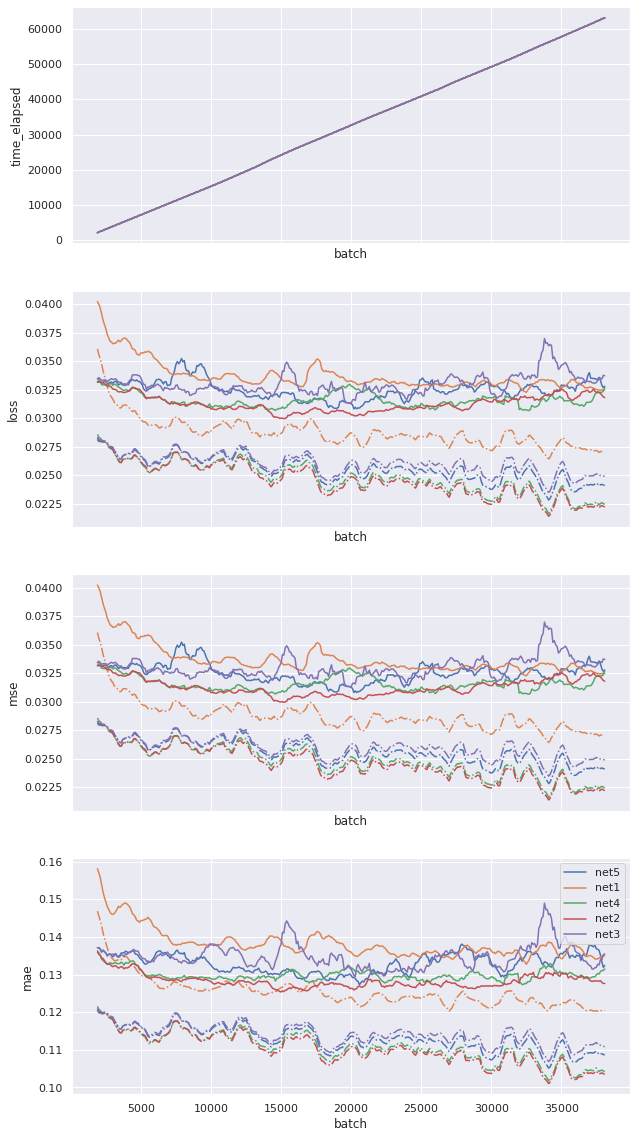

In [109]:
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
sns.set()


fig, axes = plt.subplots(4,1, sharex=True, figsize=(10,20))
axes = axes.flatten()
plot_metrics = ['time_elapsed', 'loss', 'mse', 'mae']

for ax, metric in zip(axes, plot_metrics):
    colors = cycle(prop_cycle.by_key()['color'])
    
    for i in range(len(model_dumps)):
        c = next(colors)
        df_ = dfs[i].iloc[10:].rolling(10).mean()
        if metric=='time_elapsed':
            ax.plot(df_.index, df_[metric], label=model_dumps[i], color=c)
        else:
            ax.plot(df_.index, df_['train_'+metric], linestyle='-.', color=c)
            ax.plot(df_.index, df_['test_'+metric], linestyle='-', label=model_dumps[i], color=c)
    ax.set_xlabel('batch')
    ax.set_ylabel(metric)
ax.legend()
plt.show()

In [108]:
# Calculate the table of most recent metrics for the models
final_results_df = {}
for i,model in enumerate(model_dumps):
    df = dfs[i].iloc[-10:].mean()
    for ind in df.index:
        if ind in final_results_df.keys():
            final_results_df[ind].append(df[ind])
        else:
            final_results_df[ind] = [df[ind]]
pd.DataFrame(final_results_df, index=model_dumps).sort_values('test_loss').drop(['Unnamed: 0','train_loss','test_loss' ], axis=1)

,time_elapsed,train_mse,train_mae,test_mse,test_mae
net2,63148.296390,0.022193,0.103453,0.031805,0.127625
net1,63148.377977,0.027036,0.120431,0.032486,0.135010
net4,63148.126250,0.022427,0.104168,0.032693,0.131494
net5,63148.050577,0.024089,0.108620,0.032803,0.132385
net3,63148.216374,0.024900,0.110823,0.033725,0.135522


## Plot some example sequences from best trained models
<a id='sequences' ></a>

Been having some cuda memory errors so move nets to cpu for simplicity

In [88]:
def slice_test_batch(sl):
    return {k:v[sl] for k, v in test_batch.items()}

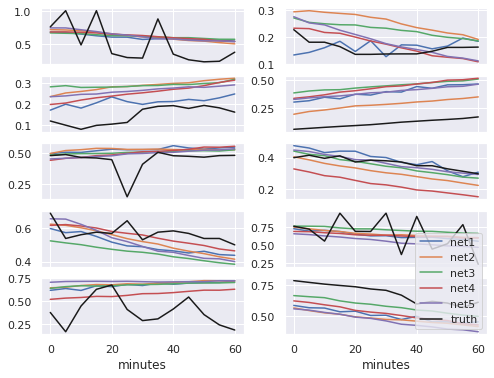

In [101]:
n = 10
np.random.seed(619987)
cs = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

inds = np.random.randint(0, len(test_batch['y']), n)

fig, axes = plt.subplots(5,2, figsize=(8,6), sharex=True)
axes[4,0].set_xlabel('minutes')
axes[4,1].set_xlabel('minutes')

axes = axes.flatten()

x = np.arange(0, 65, 5)

for i, ind in enumerate(inds):
    batch = slice_test_batch(slice(ind, ind+2))
    for ci, container in enumerate(containers):
        linestyle = '-.' if 'climatology' in container.run_name else '-'
            
        axes[i].plot(x, container.best_model(batch).cpu().detach().numpy()[0], color=cs[ci],  
                     label=container.run_name, linestyle=linestyle)
    axes[i].plot(x, batch['y'][0].cpu().detach().numpy(), color='k', label='truth')

axes[i].legend()
#plt.tight_layout()
#plt.savefig("sequence_predictions.png")
plt.show()

## Look at model accuracy throughout sequence
<a id='accuracy' ></a>


In [102]:
def torch_nan_mse_axis(ypred, y):
    mask = (~torch.isnan(y)).type(torch.float16)
    dy2 = ((y-ypred)*mask)**2
    return (dy2/mask.sum(axis=0)).sum(axis=0)

def torch_nan_mae_axis(ypred, y):
    mask = (~torch.isnan(y)).type(torch.float16)
    dy2 = torch.abs((y-ypred)*mask)
    return (dy2/mask.sum(axis=0)).sum(axis=0)

In [103]:
mae_list = []
mse_list = []

for container in containers:
    mae_list.append(
        torch_nan_mae_axis(
            container.best_model(test_batch), 
            test_batch['y']
        ).cpu().detach().numpy())
    
    mse_list.append(
        torch_nan_mse_axis(
            container.best_model(test_batch), 
            test_batch['y']
        ).cpu().detach().numpy())

In [104]:
mae_with_time = pd.DataFrame(mae_list, index=[c.run_name for c in containers], columns=np.arange(0,65,5)).T
mse_with_time = pd.DataFrame(mse_list, index=[c.run_name for c in containers], columns=np.arange(0,65,5)).T

In [105]:
mae_with_time

,net1,net2,net3,net4,net5
0,0.121826,0.117126,0.120605,0.118958,0.119263
5,0.122681,0.118469,0.118835,0.118835,0.119202
10,0.119202,0.115845,0.117004,0.117432,0.117981
15,0.123718,0.118164,0.121094,0.120789,0.119873
20,0.125122,0.120422,0.123901,0.122803,0.122925
25,0.127075,0.121155,0.126465,0.124023,0.124939
30,0.133789,0.127197,0.129883,0.127075,0.130737
35,0.133179,0.126465,0.130005,0.126709,0.129883
40,0.135620,0.127441,0.130859,0.126953,0.130493
45,0.139038,0.130859,0.134033,0.130493,0.135132


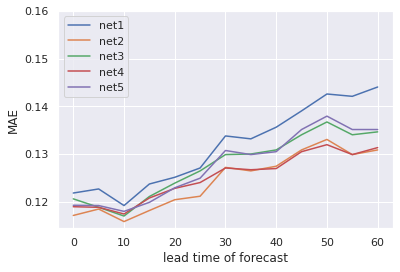

In [107]:
mae_with_time.loc[:,:'recreation_with_widestview'].plot()
plt.ylim(None, 0.16)
plt.xlabel('lead time of forecast')
plt.ylabel('MAE')
plt.show()

In [659]:
mse_with_time

,net1,net2,net3
0,NaN,0.027740,0.027679
5,NaN,0.029694,0.029572
10,NaN,0.029099,0.029144
15,NaN,0.029617,0.030212
20,NaN,0.030090,0.030136
25,NaN,0.031647,0.031525
30,NaN,0.031891,0.031372
35,NaN,0.031494,0.031235
40,NaN,0.032837,0.032501
45,NaN,0.031342,0.031235


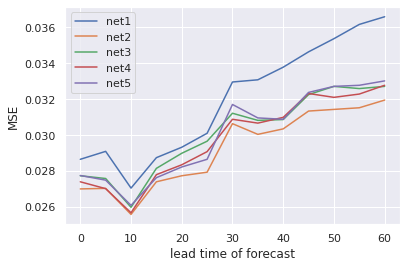

In [123]:
mse_with_time.plot()
plt.xlabel('lead time of forecast')
plt.ylabel('MSE')
plt.show()

## Plot distribution of predicted and true values of PV
<a id='distributions' ></a>

In [111]:
y_df = pd.DataFrame(test_batch['y'].cpu().detach().numpy(), columns=np.arange(0,65, 5))

In [113]:
container = [c for c in containers if c.run_name=='net2'][0]
ypref_df = pd.DataFrame(container.best_model(test_batch).cpu().detach().numpy(), columns=np.arange(0,65, 5))

In [114]:
ycomp_df = pd.melt(y_df, var_name='lead_time', value_name='y').join(pd.melt(ypref_df, var_name='lead_time', value_name='ypred').drop('lead_time', axis=1))

In [115]:
ycomp_df

,lead_time,y,ypred
0,0,0.281006,0.395996
1,0,0.182861,0.153931
2,0,0.003901,0.053986
3,0,0.002705,0.024658
4,0,0.306885,0.207275
...,...,...,...
12995,60,0.046295,0.130005
12996,60,0.273926,0.269287
12997,60,0.217529,0.217285
12998,60,0.932129,0.557129


In [119]:
ycomp_df.lead_time= pd.Categorical(ycomp_df.lead_time)

In [120]:
lead_time_unique = np.unique(ycomp_df.lead_time)
palette = sns.color_palette('plasma', n_colors=len(lead_time_unique))
colordict={k:colour for k, colour in zip(lead_time_unique,palette)}

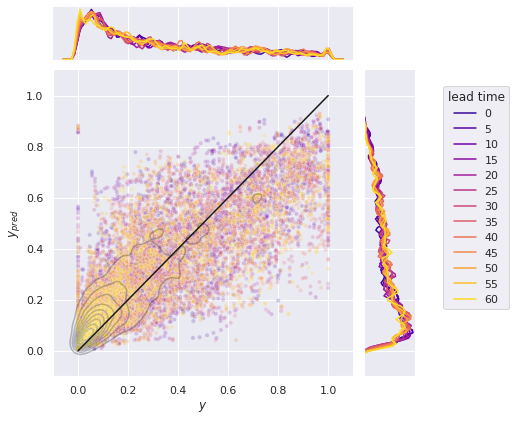

In [121]:
#ycomp_df.plot.scatter(x='y', y='ypred')

import seaborn as sns
import matplotlib as mpl

# set up plot grid structure
grid = sns.JointGrid(x='y', y='ypred', data=ycomp_df)

bw=0.02
kernel='epa'

# add central scatter and contour plots
g = grid.plot_joint(sns.scatterplot, hue='lead_time', data=ycomp_df, palette=colordict, size=1, alpha=0.2, legend=False)
grid.plot_joint(sns.kdeplot, alpha=0.3, bw=bw, kernel=kernel)

# add density plots on margins
for lt in lead_time_unique:
    sns.kdeplot(ycomp_df.query("lead_time==@lt").loc[:, 'y'], ax=g.ax_marg_x, legend=False, color=colordict[lt], bw=bw, kernel=kernel)
    sns.kdeplot(ycomp_df.query("lead_time==@lt").loc[:, 'ypred'], ax=g.ax_marg_y, vertical=True, legend=False, color=colordict[lt], bw=bw, kernel=kernel)

# formating
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel('$y$')
plt.ylabel('$y_{pred}$')

# add guidline
plt.plot([0,1], [0,1], color='k')

# add legend on new axis
cbar_ax = g.fig.add_axes([1, 0.1, .2, .7])
cbar_ax.legend(g.ax_marg_x.get_lines(), lead_time_unique, title='lead time')
cbar_ax.set_axis_off()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f1319dfd0>,
      dtype=object)

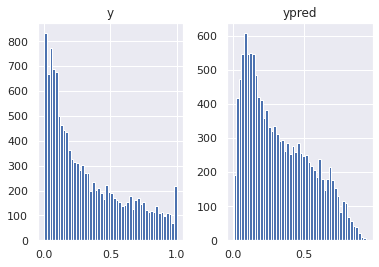

In [122]:
(ycomp_df.iloc[:, 1:]).hist(bins=50)